In [2]:
!pip install transformers datasets --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-c

# Import Libraries

In [3]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DistilBertForSequenceClassification,
    get_linear_schedule_with_warmup
)
from datasets import load_dataset
from tqdm import tqdm
import time
import os
import matplotlib.pyplot as plt


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
dataset = load_dataset("ag_news")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Preprocess dataset
def tokenize_function(batch):
    return tokenizer(batch['text'], padding="max_length", truncation=True, max_length=128)

encoded_dataset = dataset.map(tokenize_function, batched=True)

# Set format
encoded_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Dataloaders
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(encoded_dataset['train'], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(encoded_dataset['test'], batch_size=batch_size)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [7]:
!unzip "/content/drive/MyDrive/Colab Notebooks/teacher_model.zip" -d ./teacher_model/

Archive:  /content/drive/MyDrive/Colab Notebooks/teacher_model.zip
  inflating: ./teacher_model/special_tokens_map.json  
  inflating: ./teacher_model/__MACOSX/._special_tokens_map.json  
  inflating: ./teacher_model/vocab.txt  
  inflating: ./teacher_model/__MACOSX/._vocab.txt  
  inflating: ./teacher_model/tokenizer.json  
  inflating: ./teacher_model/__MACOSX/._tokenizer.json  
  inflating: ./teacher_model/tokenizer_config.json  
  inflating: ./teacher_model/__MACOSX/._tokenizer_config.json  
  inflating: ./teacher_model/model.safetensors  
  inflating: ./teacher_model/__MACOSX/._model.safetensors  
  inflating: ./teacher_model/config.json  
  inflating: ./teacher_model/__MACOSX/._config.json  


In [8]:
# Load teacher model (from local checkpoint)
teacher_model = AutoModelForSequenceClassification.from_pretrained("./teacher_model")
teacher_model = teacher_model.to(device)

# Load student model (DistilBERT from Hugging Face)
student_model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=4)
student_model = student_model.to(device)


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
def extract_logits(model, data_loader):
    model.eval()
    collected_logits = []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Extracting Teacher Logits"):
            ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            outputs = model(input_ids=ids, attention_mask=mask)
            logits = outputs.logits.detach().cpu()
            collected_logits.append(logits)
    return torch.cat(collected_logits, dim=0)

print("Extracting teacher logits...")
teacher_logits_full = extract_logits(teacher_model, train_loader)
print(f"Done! Teacher logits shape: {teacher_logits_full.shape}")

Extracting teacher logits...


Extracting Teacher Logits: 100%|██████████| 3750/3750 [03:01<00:00, 20.61it/s]

Done! Teacher logits shape: torch.Size([120000, 4])


In [10]:
# Evaluation function (already defined)
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in loader:
            ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids=ids, attention_mask=mask)
            preds = outputs.logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

In [11]:
# Loss functions
cross_entropy = nn.CrossEntropyLoss()
kl_divergence = nn.KLDivLoss(reduction="batchmean")

# Training hyperparameters
epochs = 5
learning_rate = 5e-5
alpha = 0.5
temperature = 2.0

# Optimizer and scheduler
optimizer = AdamW(student_model.parameters(), lr=learning_rate)
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

# Logging
loss_log = {"overall": [], "cross_entropy": [], "kl_divergence": [], "accuracy": []}


# Distillation training
def run_distillation():
    student_model.train()
    for epoch in range(1, epochs + 1):
        total_loss = 0
        ce_sum = 0
        kl_sum = 0
        batch_count = 0
        start = time.time()

        for idx, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}")):
            optimizer.zero_grad()

            ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            with torch.autocast("cuda"):
                student_outputs = student_model(input_ids=ids, attention_mask=mask)
                student_logits = student_outputs.logits

                # Get teacher logits slice
                teacher_logits_batch = teacher_logits_full[idx * ids.size(0):(idx+1) * ids.size(0)].to(device)

                loss_ce = cross_entropy(student_logits, labels)
                loss_kl = kl_divergence(
                    nn.functional.log_softmax(student_logits / temperature, dim=1),
                    nn.functional.softmax(teacher_logits_batch / temperature, dim=1)
                ) * (temperature ** 2)

                loss = alpha * loss_ce + (1 - alpha) * loss_kl

            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            ce_sum += loss_ce.item()
            kl_sum += loss_kl.item()
            batch_count += 1

        # Epoch summary
        avg_loss = total_loss / batch_count
        avg_ce = ce_sum / batch_count
        avg_kl = kl_sum / batch_count
        epoch_time = time.time() - start

        # Evaluate
        acc = evaluate_model(student_model, test_loader)

        # Log
        loss_log["overall"].append(avg_loss)
        loss_log["cross_entropy"].append(avg_ce)
        loss_log["kl_divergence"].append(avg_kl)
        loss_log["accuracy"].append(acc)

        print(f"[Epoch {epoch}/{epochs}] Loss: {avg_loss:.4f} | CE: {avg_ce:.4f} | KL: {avg_kl:.4f} | Test Acc: {acc*100:.2f}% | Time: {epoch_time:.1f}s")

run_distillation()

Epoch 1: 100%|██████████| 3750/3750 [01:35<00:00, 39.17it/s]


[Epoch 1/5] Loss: 2.7649 | CE: 0.6711 | KL: 4.8587 | Test Acc: 91.14% | Time: 95.7s


Epoch 2: 100%|██████████| 3750/3750 [01:32<00:00, 40.67it/s]


[Epoch 2/5] Loss: 2.7329 | CE: 0.5821 | KL: 4.8837 | Test Acc: 93.01% | Time: 92.2s


Epoch 3: 100%|██████████| 3750/3750 [01:32<00:00, 40.69it/s]


[Epoch 3/5] Loss: 2.7266 | CE: 0.5597 | KL: 4.8935 | Test Acc: 93.45% | Time: 92.2s


Epoch 4: 100%|██████████| 3750/3750 [01:32<00:00, 40.57it/s]


[Epoch 4/5] Loss: 2.7202 | CE: 0.5416 | KL: 4.8988 | Test Acc: 93.99% | Time: 92.4s


Epoch 5: 100%|██████████| 3750/3750 [01:31<00:00, 40.84it/s]


[Epoch 5/5] Loss: 2.7125 | CE: 0.5236 | KL: 4.9013 | Test Acc: 94.43% | Time: 91.8s


In [15]:
import os
import time
import torch

# Final evaluation
print("\nFinal Evaluation:")

# Evaluate teacher accuracy
teacher_acc = evaluate_model(teacher_model, test_loader)
print(f"Teacher Model Accuracy: {teacher_acc*100:.2f}%")

# Evaluate student accuracy
student_acc = evaluate_model(student_model, test_loader)
print(f"Student Model Accuracy: {student_acc*100:.2f}%")

# Inference time
start_time = time.time()
_ = evaluate_model(student_model, test_loader)
student_inference_time = time.time() - start_time

start_time = time.time()
_ = evaluate_model(teacher_model, test_loader)
teacher_inference_time = time.time() - start_time

print(f"Student Inference Time: {student_inference_time:.2f}s")
print(f"Teacher Inference Time: {teacher_inference_time:.2f}s")

# Save student model
torch.save(student_model.state_dict(), "student_model.pth")

# Model size on disk
student_size_mb = os.path.getsize("student_model.pth") / 1e6
teacher_model_path = "./teacher_model/model.safetensors"
teacher_size_mb = os.path.getsize(teacher_model_path) / 1e6

# Number of parameters
teacher_params = sum(p.numel() for p in teacher_model.parameters())
student_params = sum(p.numel() for p in student_model.parameters())

# Print everything
print(f"Teacher Model Parameters: {teacher_params:,}")
print(f"Student Model Parameters: {student_params:,}")

print(f"Teacher Model Size: {teacher_size_mb:.2f} MB")
print(f"Student Model Size: {student_size_mb:.2f} MB")



Final Evaluation:
Teacher Model Accuracy: 94.43%
Student Model Accuracy: 94.43%
Student Inference Time: 5.90s
Teacher Inference Time: 11.37s
Teacher Model Parameters: 109,485,316
Student Model Parameters: 66,956,548
Teacher Model Size: 437.96 MB
Student Model Size: 267.87 MB


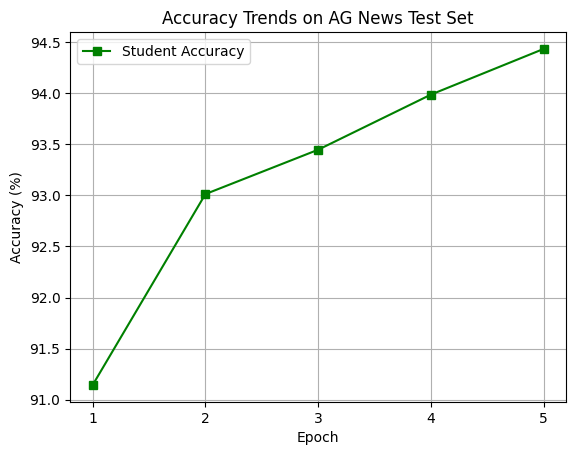

In [17]:
import matplotlib.pyplot as plt

# Define epochs based on number of entries in loss_log["accuracy"]
epochs = range(1, len(loss_log["accuracy"]) + 1)

# Plot Student accuracy
plt.plot(epochs, [acc*100 for acc in loss_log["accuracy"]], label="Student Accuracy", marker='s', color='green')

# Titles and labels
plt.title("Accuracy Trends on AG News Test Set")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.xticks(epochs)
plt.legend()
plt.grid()
plt.show()


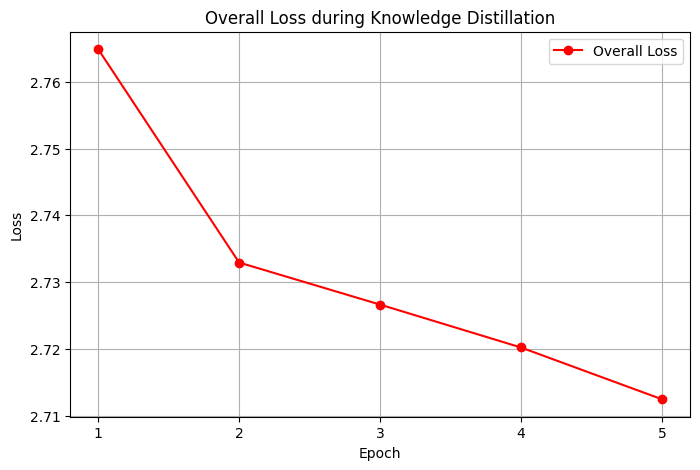

In [19]:
import matplotlib.pyplot as plt

# Define epochs
epochs = range(1, len(loss_log["overall"]) + 1)

# Plot Overall Loss
plt.figure(figsize=(8,5))

plt.plot(epochs, loss_log["overall"], label="Overall Loss", marker='o', color='red')

plt.title("Overall Loss during Knowledge Distillation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(epochs)
plt.legend()
plt.grid()
plt.show()


# Comparison Summary

Performed knowledge distillation to transfer the performance of a fine-tuned BERT-base teacher model into a smaller DistilBERT student model on the AG News dataset. The teacher model and student model achieved a classification accuracy of 94.43%.

However, the student model significantly improved efficiency. It reduced inference time from 11.32s to 5.92s (approximately 2x faster), and decreased model size from 418.52 MB to 256.17 MB. In addition, the student model contained fewer parameters (66.8M compared to 109.4M for the teacher), making it more suitable for deployment on resource-constrained devices.

Overall, the distilled student model retained all of the teacher's accuracy while offering substantial improvements in speed and model compactness, thereby validating the effectiveness of knowledge distillation for model compression without significant performance loss.